In [1]:
using Plots
function metric(x1,y1,x2,y2)
    return sqrt((x1-x2)^2 + (y1-y2)^2)
end

Nx = 100
Ny =50
q = 9
τ=1.05
Nt = 8000
u0 = 0.2

cx = [0,0,1,1,1,0,-1,-1,-1]
cy = [0,1,1,0,-1,-1,-1,0,1]
w = [4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36]



9-element Vector{Float64}:
 0.4444444444444444
 0.1111111111111111
 0.027777777777777776
 0.1111111111111111
 0.027777777777777776
 0.1111111111111111
 0.027777777777777776
 0.1111111111111111
 0.027777777777777776

In [2]:
function stream(f)
    for i=1:q
        f[:,:,i] = circshift(f[:,:,i],(cx[i],0))
        f[:,:,i] = circshift(f[:,:,i],(0,cy[i]))
    end
    return f
end
function macroscopic(f)
    ρ = reshape(sum(f,dims=3),Nx,Ny)
    ux = reshape(sum(f[:,:,i] * cx[i] for i in 1:q)./ρ,Nx,Ny)
    uy = reshape(sum(f[:,:,i] * cy[i] for i in 1:q)./ρ,Nx,Ny)
    return ρ,ux,uy
end
function InitialConditions(u0)
    f= zeros(Nx,Ny,q)
    ux = zeros(Nx,Ny)
    uy = zeros(Nx,Ny)
    ρ = ones(Nx,Ny)
    for i = 2:Nx-1
        ux[i,Ny] = u0
    end
    return f,ρ,ux,uy
end
function collide(f,ρ,ux,uy)
    feq = zeros(Nx,Ny,q)
    for i in 1:q
        feq[:,:,i] =   w[i] *ρ .* ( 3*(cx[i]*ux+cy[i]*uy)+9/2*(cx[i]*ux+cy[i]*uy).^2- 3*(ux.^2 + uy.^2)/2 .+1.0)
    end
    f = f - (f - feq)/τ
    return f
end

function object(f,ux,uy,cyl)
    boundary = f[cylinder,:]
    boundary = boundary[:,[1,6,7,8,9,2,3,4,5]]
    ux[cylinder] .= 0
    uy[cylinder] .= 0
    f[cylinder,:] = boundary
    return f,ux,uy
end

function BoundaryConditions(f,ux,uy,u0)
#=     #Right boundary and left 
    f[Nx,:,8] = f[Nx-1,:,8]
    f[Nx,:,7] = f[Nx-1,:,7]
    f[Nx,:,9] = f[Nx-1,:,9]
 =#

    #bottom and top
    f[:,1,2] = f[:,1,6]
    f[:,1,3] = f[:,1,7]
    f[:,1,9] = f[:,1,5]
    ux[:,1] .= 0
    uy[:,1] .= 0

    #Top
    ux[:,Ny] .= u0
    f[:,Ny,6] = f[:,Ny,2]
    f[:,Ny,7] = f[:,Ny,3] +0.5*(f[:,Ny,4]-f[:,Ny,8]) - 0.5*ux[:,Ny]
    f[:,Ny,5] = f[:,Ny,9] + 0.5*(f[:,Ny,8]-f[:,Ny,4]) + 0.5*ux[:,Ny]
    return f,ux,uy
end


BoundaryConditions (generic function with 1 method)

In [3]:
for test = 1:9
println(test," " ,cx[test],cy[test])
end

1 00
2 01
3 11
4 10
5 1-1
6 0-1
7 -1-1
8 -10
9 -11


In [4]:
cylinder = BitArray(100 < 20 for i in 1:Nx, j in 1:Ny)
strength = zeros(Nx,Ny,Nt)
uxity = zeros(Ny,Nt)

f,ρ,ux,uy = InitialConditions(u0)
for j=1:Nt
    #stream
    f = collide(f,ρ,ux,uy)
    f = stream(f)
    f,ux,uy = object(f,ux,uy,cylinder)
    f,ux,uy = BoundaryConditions(f,ux,uy,u0)
    #macroscopic
    ρ,ux,uy= macroscopic(f)
    #Obstacle Conditions 
    #collisions
    strength[:,:,j] = sqrt.(ux.^2 + uy.^2)
    uxity[:,j] = ux[Integer(Nx/2),:]
end


┌ Info: Saved animation to c:\Users\batti\Documents\Uni\ComputationalProjects\Julia\LatticeBoltzmann\Couette\Velocity.gif
└ @ Plots C:\Users\batti\.julia\packages\Plots\kLeqV\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\batti\\Documents\\Uni\\ComputationalProjects\\Julia\\LatticeBoltzmann\\Couette\\Velocity.gif")
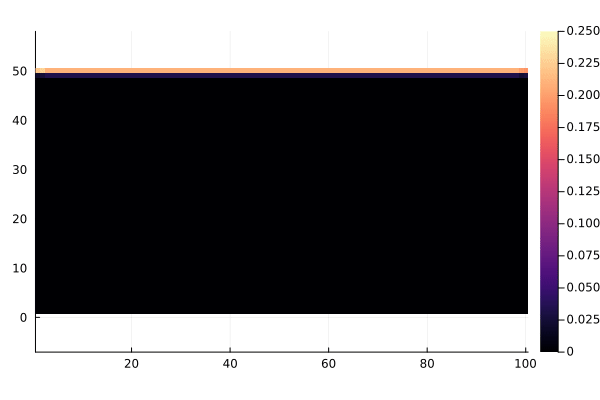

In [5]:
VelocityAnim = @animate for i=1:Nt
    heatmap(transpose(strength[:,:,i]),aspect_ratio=1,color=:magma, clim=(0,0.25))
end every 10
gif(VelocityAnim, "Velocity.gif", fps = 60)

┌ Info: Saved animation to c:\Users\batti\Documents\Uni\ComputationalProjects\Julia\LatticeBoltzmann\Couette\VelocityProfile.gif
└ @ Plots C:\Users\batti\.julia\packages\Plots\kLeqV\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\batti\\Documents\\Uni\\ComputationalProjects\\Julia\\LatticeBoltzmann\\Couette\\VelocityProfile.gif")
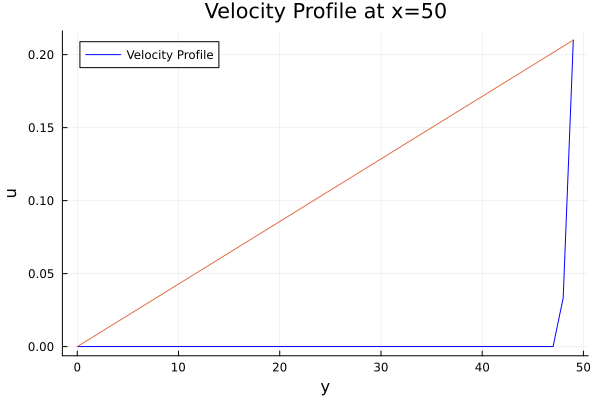

In [9]:
p(x) = uxity[Ny,8000]*x/(Ny-1)
VelocityProfileAnim = @animate for i=1:Nt
    plot(0:Ny-1,uxity[:,i],label="Velocity Profile",xlabel="y",ylabel="u",title="Velocity Profile at x=50",color=:blue)
    plot!(p,0,Ny-1,label="")
end every 10
gif(VelocityProfileAnim, "VelocityProfile.gif", fps = 60)